# Visualizing ConvNets with Tensorflow
### Building ConvNets from scratch with TensorFlow and TensorBoard.
#### <a href="https://www.oreilly.com/ideas/visualizing-convolutional-neural-networks">Article in O'Reilly Ideas AI</a>
#### <a href="https://github.com/wagonhelm/Visualizing-Convnets/">GitHub Code Repo</a>

By Justin Francis September 15, 2017

Given all of the higher level tools that you can use with TensorFlow, such as <a href="https://www.tensorflow.org/get_started/tflearn">`tf.contrib.learn`</a> and <a href="https://keras.io/">`Keras`</a>, one can very easily build a convolutional neural network with a very small amount of code. But often with these higher level applications, you cannot access the little inbetween bits of the code, and some of the understanding of what’s happening under the surface is lost.

In this tutorial, I’ll walk you through how to build a convolutional neural network from scratch, using just the low-level `TensorFlow` and visualizing our graph and network performance using `TensorBoard`. If you don't understand some of the basics of a fully connected neural network, I highly recommend you first check out <a href="https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow">Not another MNIST tutorial with TensorFlow</a>. Throughout this article, I will also break down each step of the convolutional neural network to its absolute basics so you can fully understand what is happening in each step of the graph. By building this model from scratch, you can easily visualize different aspects of the graph so that you can see each layer of convolutions and use them to make your own inferences. I will only highlight major aspects of the code, so if you would like to follow this code step-by-step, you can checkout the corresponding <a href="https://github.com/wagonhelm/Visualizing-Convnets/blob/master/visualizingConvnets.ipynb">Jupyter Notebook on GitHub</a>.

First, let’s get started with loading our dependencies, which includes a group of helper functions I made called imFunctions for processing the image data.

We start with importing our dependencies including the imFuctions which I made myself.

In [1]:
import imFunctions as imf
import tensorflow as tf
import scipy.ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt
import numpy as np

print("Python libraries imported!")

Python libraries imported!


## Gathering a data set

Getting started, I had to decide which image data set to use. I decided to use the University of Oxford, Visual Geometry Group’s <a href="http://www.robots.ox.ac.uk/~vgg/data/pets/">pet data set</a>. I chose this data set for a few reasons: it is very simple and well-labeled, it has a decent amount of training data, and it also has bounding boxes—to utilize if I want to train a detection model down the road. Another data set I thought would be excellent for a building a first model was the <a href="https://www.kaggle.com/alexattia/the-simpsons-characters-dataset">Simpsons data set</a> found on Kaggle, which has a great amount of simple data on which to train.

We can then download and extract the images using `imFunctions`. These functions below will download and extract the dataset for you. 

In [2]:
imf.downloadImages('annotations.tar.gz', 19173078)
imf.downloadImages('images.tar.gz', 791918971)
imf.maybeExtract('annotations.tar.gz')
imf.maybeExtract('images.tar.gz')

File 'annotations.tar.gz' allready downloaded :)
File images.tar.gz not expected size, forcing download
Attempting to download: images.tar.gz
Downloaded '/Users/claudecoulombe/git/Visualizing-Convnets/images.tar.gz' successfully
annotations already present - Skipping extraction of annotations.tar.gz
Extracting data for images:


We can then sort the images into separate folders, including training and test folders. The number in the `sortImages` function represents the percentage of test data you would like to separate from the training data.

Here you can decide what percentage of your data you would like to use as test data.

In [3]:
imf.sortImages(0.15)

Images sorted


We can then build our data set into a numpy array with a corresponding one hot vector to represent our class. This will also subtract the image mean from all of the training and test imagesa standard practice when building a convnet. The function will ask you what classes you would like to include—due to my limited amount of GPU ram (3GB), I choose a very small data set that tries to differentiate two breeds of dogs: a Shiba Inu from a Samoyed.

This function will build all your training data into numpy arrays and print out your classes associated one hot vector.  This will also subtract the mean value of your train data from both the test and train data, this is a standard practice in building convnets.

#### Note - PIL Bug On Mac OS X 

On my Macintosh PowerBook, I've got a problem with the PIL - Python Image Library on .jpeg files. After a lot of work, I finally found a workaround. I must convert all the .jpg files to .png files. Below, the steps in order to process the shibainu images.

> mkdir images/shibainu/train_png

> for f in images/shibainu/train/*.jpg; do sips -s format png $f --out images/shibainu/train_png; done

> rm -R images/shibainu/train

> mv images/shibainu/train_png/ images/shibainu/train

> mkdir images/shibainu/test_png

> for f in images/shibainu/test/*.jpg; do sips -s format png $f --out images/shibainu/test_png; done

> rm -R images/shibainu/test

> mv images/shibainu/test_png/ images/shibainu/test

In [5]:
train_x, train_y, test_x, test_y, classes, classLabels = imf.buildDataset()

Do you want to use .DS_Store in your dataset?  [y/n/break]n
Do you want to use samoyed in your dataset?  [y/n/break]y
Do you want to use shibainu in your dataset?  [y/n/break]y
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str' at 0x1002329a0>
<class 'str

Let's just load one image to mess around with in the future.

#### Note - PIL Bug On Mac OS X 
Again, in order to avoid the PIL bug with Mac OS, we replace `scipy.misc.imshow(image)` by a matplotlib function.

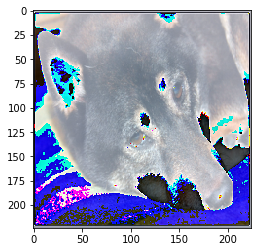

In [18]:
import matplotlib.pyplot as plt
image = train_x[202]
# scipy.misc.imshow(image)
plt.imshow(np.uint8(image))
plt.show()

## How convolutions and pooling work

Now that we have a data set to work with, let’s step back a bit and look at the absolute basics of how convolutions work. Before jumping into a color convolutional filter, let's look at a grayscale one to make sure everything is clear. Let's make a `7x7` filter that applies `4` different feature maps. TensorFlow’s `conv2d` function is fairly simple and takes in `4` variables: input, filter, strides, and padding. On the TensorFlow site, they describe the `conv2d` function as follows:

> Computes a 2-D convolution given 4-D input and filter tensors.

> Given an input tensor of shape `[batch, in_height, in_width, in_channels]` and a filter / kernel tensor of shape `[filter_height, filter_width, in_channels, out_channels]`.

### How do the filters work?

Before jumping into a color convolutional filter let's look at a grayscale one to make sure everything is clear. Let's make a `7x7` filter that applies `4` different effects.  

<a href="https://www.tensorflow.org/api_docs/python/tf/nn/conv2d">TensorFlow explains the conv2d kernel as:</a> <i>a filter / kernel tensor of shape `[filter_height, filter_width, in_channels, out_channels]`</i>

Since we are working with grayscale our `in_channels` will be `1` and since we are applying `4` filters our `out_channels` will be `4`. Let’s apply the following four filters/kernels to just one of our images, or a batch of 1:

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_2-fec5d4f15a60986e8965db5631d00613.png"/>
<center>Figure 2. Image courtesy of Justin Francis.</center>
<br/>

And let’s see how this filter affected our grayscaled image input.

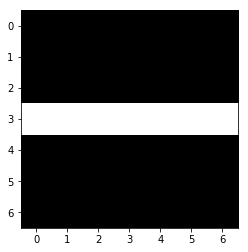

In [11]:
filters = np.zeros([7,7,1,4])

filters[3,:,0,0] = 1
plt.imshow(filters[:,:,:,0].reshape(7,7), cmap='gray')
plt.show()

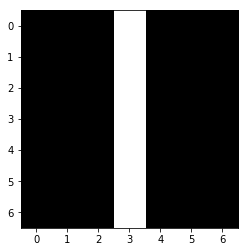

In [12]:
filters[:,3,0,1] = 1
plt.imshow(filters[:,:,:,1].reshape(7,7), cmap='gray')
plt.show()

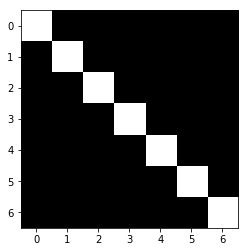

In [13]:
filters[:,:,0,2] = np.eye(7,7)
plt.imshow(filters[:,:,:,2].reshape(7,7), cmap='gray')
plt.show()

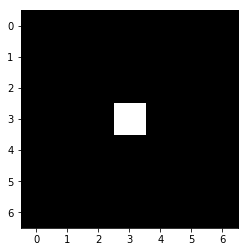

In [14]:
filters[:,:,:,3] -= 1
filters[3,3,:,3] = 8
plt.imshow(filters[:,:,:,3].reshape(7,7), cmap='gray')
plt.show()

### Applying convolution of filters on a complex image
Next let's convert our image to grayscale. Then we slide our kernel over the image with a padding around the border to apply our filter and maintain our images shape.  This website (http://setosa.io/ev/image-kernels/) does a excellent job of visualizing this process.  Notice we have to convert our image into a 4d tensor.


In [24]:
gray = np.mean(image,-1)
X = tf.placeholder(tf.float32, shape=(None, 224, 224, 1))
conv = tf.nn.conv2d(X, filters, [1,1,1,1], padding="SAME")
test = tf.Session()
test.run(tf.global_variables_initializer())
filteredImage = test.run(conv, feed_dict={X: gray.reshape(1,224,224,1)})
tf.reset_default_graph()

This will return a 4d tensor of (1, 224, 224, 4). We can reset the TensorFlow graph since we wont be using this node again.


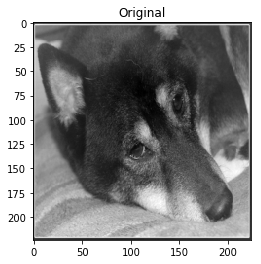

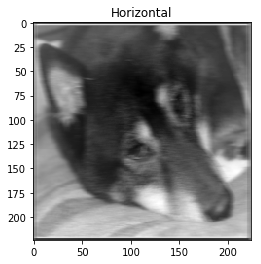

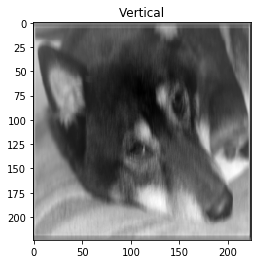

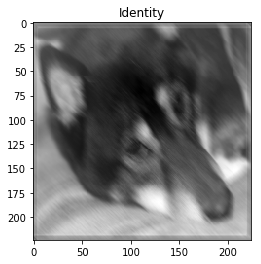

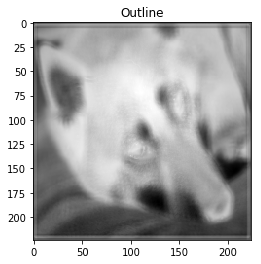

In [25]:
plt.imshow(gray, cmap='gray')
plt.title('Original')
plt.show()
labels = ['Horizontal', 'Vertical', 'Identity', 'Outline']
for i in range(4):
    plt.title(labels[i])
    plt.imshow(filteredImage[:,:,:,i].reshape(224,224),cmap = 'gray')
    plt.show()

This will return a 4d tensor of `(1, 224, 224, 4)`, which we can use to visualize the four filters:

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_3-6c594d8ea763f3ce39242a4e798b8514.png"/ width=300>
<center>Figure 3. Image courtesy of Justin Francis.</center>
<br/>

It's clear to see that convolutions of filter kernels are very powerful. Convolutions of filter kernels can drastically change an image.  To break it down, our `7x7` kernel is striding in steps of one over `49` of the image’s pixels at a time, the value of each pixel is then multiplied by each kernel value, and then all of the `49` values are added together to make one pixel. If the idea of image filter kernels is still not making sense, I highly recommend this <a href="http://setosa.io/ev/image-kernels/">website</a> — they do an excellent job of visualizing kernels.
<br/><br/>
Now, in essence, most convolutional neural networks consist of just `convolutions` and `poolings`. Most commonly, a `3x3` kernel filter is used for `convolutions`. Particularly, `max poolings` with a stride of `2` and kernel size of `2x2` are just an aggressive way to essentially reduce an image’s size based upon its maximum pixel values within a kernel (i.e. dimension reduction). Here is a basic example of a `2x2` kernel with a stride of `2` in both dimensions.

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_4-87c227113cdd0b73d842267404d4aa00.gif">
<!-- <img src="imageFiles/pool.gif"> -->
<center>Figure 4. Max Pooling kernel size of 2x2 and stride of 2<br/>
Image courtesy of Justin Francis.</center>

Now, for both `conv2d` and `max pooling`, there are 2 options to choose from for `padding`: `"VALID"` which will shrink an input and `"SAME"`, which will maintain the input image size by adding zeros around the edges of the input. Here is an example of a `max pool` with a `3x3` kernel, with a `stride` of `1` to compare the `padding` options:

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_5-d83a3121b7729ec38ef320c31abcaec8.gif">
<!-- <img src="imageFiles/pool2.gif"> -->
<center>Figure 5. Max Pooling kernel size of 3x3 and stride of 1 with 'SAME' (add 0's) or 'VALID' padding<br/>
Image courtesy of Justin Francis.</center>

## Choosing a model

Next, I had to decide on the model (or architecture) of my convolutional neural network. Some very popular models are <a href="http://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf">GoogLeNet</a> or <a href="https://arxiv.org/pdf/1409.1556.pdf">VGG16</a>, which both have multiple convolutions designed to detect images from the 1000 class data set imagenet. I decided on a much simpler 4 convolutional neural network shown below:

<!-- <img src="imageFiles/convnet2.png"> -->
<img src="https://d3ansictanv2wj.cloudfront.net/Figure_1-a15bf6f652717e8f6c0ff4a7f132d594.png"/>
<center>Figure 1. Image courtesy of Justin Francis.</center>

To break down this model, it starts with a `224x224x3` image, which is is convolved to `32` feature maps, based from the previous `3` channels. We than convolve this group of `32` feature maps together into another `32` features. This is then pooled into a `112x112x32` image, which we convolve into `64` feature maps twice followed, with a final pooling of `56x56x64`. Each unit of this final pooled layer is then fully connected to `512` neurons, and then finally put through a softmax layer based upon the number of classes.

## Building the convnet

Now that we've got the basics covered, let’s start building our convolutional neural network model.  We can start with our placeholders. `X` will be our input placeholder, which we will feed our images into, and `Y_` will be the true classes of a set of images.  We will also define keepRate which we will later use for dropout.

In [26]:
X = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))
Y_ = tf.placeholder(tf.float32, [None, classes])
keepRate1 = tf.placeholder(tf.float32)
keepRate2 = tf.placeholder(tf.float32)

### Convolution 1

We will create all parts for each convolution process under one scope. Scope’s are extremely useful for visualizing the graph in TensorBoard down the road because they will group everything into one expandable object. We create our first set of filters with a kernel size of 3x3, which takes in 3 channels and outputs 32 filters. This means that for every one of the 32 filters, there will be 3x3 kernel weights for the R, G, and B channels. It’s very important that the weight values for our filter are initialized using truncated normal so we have multiple random filters that TensorFlow will adapt to fit our model.

In [27]:
# CONVOLUTION 1 - 1
with tf.name_scope('conv1_1'):
    filter1_1 = tf.Variable(tf.truncated_normal([3, 3, 3, 32], dtype=tf.float32,
                            stddev=1e-1), name='weights1_1')
    stride = [1,1,1,1]
    conv = tf.nn.conv2d(X, filter1_1, stride, padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                         trainable=True, name='biases1_1')
    out = tf.nn.bias_add(conv, biases)
    conv1_1 = tf.nn.relu(out)

If we want to visualize our initial filters we can do so by running our image through the conv1_1 node.

In [33]:
# Un-comment below if you want to visualize
# test.run(tf.global_variables_initializer())
# filteredImage = test.run(conv1_1, feed_dict={X: image.reshape(1,224,224,3)})
# for i in range(32):
#     plt.imshow(filteredImage[:,:,:,i].reshape(224,224))
#     plt.show()

You can see the the random initialized weights are already beginnnig to act like a pretty good edge detector.

At the end of our first convolution, `conv1_1`, we finish off by applying ReLU, which acts as a threshold by assigning every negative number to `0`. Continuing on to the next convolution, we convolve those `32` features together into another `32` features. You can see `conv2d` assigns the input to be the output of the first convolutional layer.

In [35]:
# CONVOLUTION 1 - 2
with tf.name_scope('conv1_2'):
    filter1_2 = tf.Variable(tf.truncated_normal([3, 3, 32, 32], dtype=tf.float32,
                                                stddev=1e-1), name='weights1_2')
    conv = tf.nn.conv2d(conv1_1, filter1_2, [1,1,1,1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                         trainable=True, name='biases1_2')
    out = tf.nn.bias_add(conv, biases)
    conv1_2 = tf.nn.relu(out)

We then pool to shrink the image in half.

In [36]:
# POOLING 1
with tf.name_scope('pool1'):
    pool1_1 = tf.nn.max_pool(conv1_2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='pool1_1')
    pool1_1_drop = tf.nn.dropout(pool1_1, keepRate1)

This last part involves using dropout on the pool layer which we will use during training (we will go into more detail on that later). We then follow with `2` more convolutions, with `64` features and another pool. Notice that the first convolution has to convert the previous `32` feature channels into `64`.

In [37]:
# CONVOLUTION 2 - 1
with tf.name_scope('conv2_1'):
    filter2_1 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_1')
    conv = tf.nn.conv2d(pool1_1_drop, filter2_1, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_1')
    out = tf.nn.bias_add(conv, biases)
    conv2_1 = tf.nn.relu(out)
    
# CONVOLUTION 2 - 2
with tf.name_scope('conv2_2'):
    filter2_2 = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_2')
    conv = tf.nn.conv2d(conv2_1, filter2_2, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_2')
    out = tf.nn.bias_add(conv, biases)
    conv2_2 = tf.nn.relu(out)
    
# POOL 2
with tf.name_scope('pool2'):
    pool2_1 = tf.nn.max_pool(conv2_2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='pool2_1')
    pool2_1_drop = tf.nn.dropout(pool2_1, keepRate1)

Let's take a peak at what the final convolutional layer looks like

In [ ]:
# Un-comment below if you want to visualize

#test.run(tf.global_variables_initializer())
#filteredImage = test.run(conv2_2, feed_dict={X: image.reshape(1,224,224,3), keepRate1: 1})
#for i in range(64):
#    plt.imshow(filteredImage[:,:,:,i].reshape(112,112))
#    plt.show()

Next, we create a `512` neurons, fully connected layer, which will have a weight connection for each pixel of our `56x56x64` `pool2_1` layer. That’s more than `100` millions different weight values! In order to calculate our fully connected network, we have to flatten the input into `1` dimension, and then we can multiply it by our weights and add our bias.

In [38]:
#FULLY CONNECTED 1
with tf.name_scope('fc1') as scope:
    shape = int(np.prod(pool2_1_drop.get_shape()[1:]))
    fc1w = tf.Variable(tf.truncated_normal([shape, 512], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_1')
    fc1b = tf.Variable(tf.constant(1.0, shape=[512], dtype=tf.float32),
                       trainable=True, name='biases3_1')
    pool2_flat = tf.reshape(pool2_1_drop, [-1, shape])
    out = tf.nn.bias_add(tf.matmul(pool2_flat, fc1w), fc1b)
    fc1 = tf.nn.relu(out)
    fc1_drop = tf.nn.dropout(fc1, keepRate2)

Last, we have our softmax with its associated weights and bias, and finally our output `Y`.

In [39]:
#FULLY CONNECTED 3 & SOFTMAX OUTPUT
with tf.name_scope('softmax') as scope:
    fc2w = tf.Variable(tf.truncated_normal([512, classes], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_2')
    fc2b = tf.Variable(tf.constant(1.0, shape=[classes], dtype=tf.float32),
                       trainable=True, name='biases3_2')
    Ylogits = tf.nn.bias_add(tf.matmul(fc1_drop, fc2w), fc2b)
    Y = tf.nn.softmax(Ylogits)

## Create loss & optimizer

Now, we can start developing the training aspect of our model. First, we have to decide the batch size; I couldn’t use more than `10` without running out of GPU memory. Then we have to decide the number of `epochs`, which is the number of times the algorithm will cycle through all the training data in batches, and lastly we have to decide our learning rate `alpha`.

In [69]:
# numEpochs = 400
numEpochs = 100
batchSize = 10
alpha = 1e-5

Then we create some scopes for our cross entropy, accuracy checker, and back propagation optimizer.

In [70]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    loss = tf.reduce_mean(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)

We can then create our session and initialize all our variables.

In [71]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## Create summaries for TensorBoard

Now, we also will want to utilize `TensorBoard` so we can visualize how well our classifier is doing. We will create two plots: one for our training set and one for our test set. We can visualize our graph network by using the `add_graph` function. We will measure our total loss and accuracy using summary scalar, and merge our summaries together so we only have to call `write_op` to log our scalars.

In [72]:
writer_1 = tf.summary.FileWriter("/tmp/cnn/train")
writer_2 = tf.summary.FileWriter("/tmp/cnn/test")
writer_1.add_graph(sess.graph)
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
tf.summary.histogram("weights1_1", filter1_1)
write_op = tf.summary.merge_all()

## Train the model

We then can set up our code for evaluation and training. We don’t want to use our summary writer for our loss and accuracy for every time step, because this would greatly slow down the classifier. So instead, we log every `5` steps.

In [73]:
steps = int(train_x.shape[0]/batchSize)

for i in range(numEpochs):
    accHist = []
    accHist2 = []
    train_x, train_y = imf.shuffle(train_x, train_y)
    for ii in range(steps):
        #Calculate our current step
        step = i * steps + ii
        #Feed forward batch of train images into graph and log accuracy
        acc = sess.run([accuracy], feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
        accHist.append(acc)
        
        if step % 5 == 0:
            # Get Train Summary for one batch and add summary to TensorBoard
            summary = sess.run(write_op, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
            writer_1.add_summary(summary, step)
            writer_1.flush()
            
            # Get Test Summary on random 10 test images and add summary to TensorBoard
            test_x, test_y = imf.shuffle(test_x, test_y)
            summary = sess.run(write_op, feed_dict={X: test_x[0:10,:,:,:], Y_: test_y[0:10], keepRate1: 1, keepRate2: 1})
            writer_2.add_summary(summary, step)
            writer_2.flush()

        #Back propigate using adam optimizer to update weights and biases.
        sess.run(train_step, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 0.2, keepRate2: 0.5})
    
    print('Epoch number {} Training Accuracy: {}'.format(i+1, np.mean(accHist)))
    
    #Feed forward all test images into graph and log accuracy
    for iii in range(int(test_x.shape[0]/batchSize)):
        acc = sess.run(accuracy, feed_dict={X: test_x[(iii*batchSize):((iii+1)*batchSize),:,:,:], Y_: test_y[(iii*batchSize):((iii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
        accHist2.append(acc)
    print("Test Set Accuracy: {}".format(np.mean(accHist2)))

Epoch number 1 Training Accuracy: 0.48235294222831726
Test Set Accuracy: 0.5166667103767395
Epoch number 2 Training Accuracy: 0.5
Test Set Accuracy: 0.4833333194255829
Epoch number 3 Training Accuracy: 0.5176470875740051
Test Set Accuracy: 0.5333333611488342
Epoch number 4 Training Accuracy: 0.5382353067398071
Test Set Accuracy: 0.5333333611488342
Epoch number 5 Training Accuracy: 0.5470588207244873
Test Set Accuracy: 0.5
Epoch number 6 Training Accuracy: 0.541176438331604
Test Set Accuracy: 0.550000011920929
Epoch number 7 Training Accuracy: 0.570588231086731
Test Set Accuracy: 0.5833333134651184
Epoch number 8 Training Accuracy: 0.5941176414489746
Test Set Accuracy: 0.6000000238418579
Epoch number 9 Training Accuracy: 0.5852941274642944
Test Set Accuracy: 0.6000000238418579
Epoch number 10 Training Accuracy: 0.5882352590560913
Test Set Accuracy: 0.5833333134651184
Epoch number 11 Training Accuracy: 0.6029411554336548
Test Set Accuracy: 0.5833333134651184
Epoch number 12 Training Accu

### Visualize graph

While this is training, let’s check out the TensorBoard results by activating TensorBoard in the terminal.

> tensorboard --logdir="/tmp/cnn/"

And navigate to: http://0.0.0.0:6006

As you can see by using scopes we are able to visualize a nice clean version of our graph.

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_6-48a2721bfb34d05e6bcd2e2b42c29d06.png" width=300/>
<!-- <img src="imageFiles/graph.png"> -->
<center>Figure 6. Computaion graph<br/>
Image courtesy of Justin Francis.</center>

### Measure performance

Let’s check out the scalar history for our accuracy and loss.

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_7-ceed56e2ff232b99a38f69a591d427f3.png"/>
<!-- <img src="imageFiles/overfit.png"> -->
<center>Figure 7. History for our accuracy and loss showing overfitting<br/>
Image courtesy of Justin Francis.</center>

You may be able to tell that we have a huge problem. For our training data, the classifier is getting `100%` accuracy and `0` loss, but our test data is only achieving `80%` at best and still getting a lot of loss. This is your obvious sign of overfitting — some classic symptoms include not enough training data, or having too many neurons.

We could create more training data by resizing, scaling, and rotating our training data, but a much easier approach is to add `dropout` to the output of our pooling and fully connected layers. This will make every training step completely cut, or drop out, a percentage of neurons randomly, in a layer. This will force our classifier to only train small sets of neurons at a time, rather than the whole set. This allows neurons to specialize in specific tasks, rather than all neurons generalizing together. Dropping out `80%` of our convolutional layers and `50%` of our fully connected layers gives some amazing results.

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_8-32208bbc230b1b61957f9e9ec47e9dbc.png"/>
<!-- <img src="imageFiles/betterfit.png"> -->
<center>Figure 8. History for our accuracy and loss showing a better fit<br/>
Image courtesy of Justin Francis.</center>

Just by dropping off neurons, we were able to achieve just under `90%` on our test data — that is almost a `10%` increase in performance! One drawback is that the classifier took about `6` times longer to train.

### Visualize evolving filters

For extra fun for every 50 training steps I passed an image through a filter and made a gif of the filters weights evolving.  It resulted in some pretty cool effects and some really good insight on how the convolutional network was working.  Here is two filters from conv1_2.

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_9-bfdc2ca87cf9941890142cd24f086e43.gif"/>
<!-- <img src="imageFiles/conv1.gif"> -->
<center>Figure 9. Results of two filters from conv1_2<br/>
Image courtesy of Justin Francis.</center>

You can see the initial weight initialization show a lot of the image but as the weights updated over time they became more focused on detecting certain edges. To my surprise I discovered that the very first convolutional kernel filter1_1 hardly changed at all. It seemed that the beginning weight initializations did good enough on their own. Going further down the network here is conv2_2, you can see it beginning to detect more abstract generalized features.

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_10-b758680d6af48163e334214af0513546.gif"/>
<!-- <img src="imageFiles/conv2.gif"> -->
<center>Figure 10. Results of two filters from conv1_2<br/>
Image courtesy of Justin Francis.</center>

You can see the initial weight initialization show a lot of the image but as the weights updated over time they became more focused on detecting certain edges.  To my surprise I discovered that the very first convolutional kernel `filter1_1` hardly changed at all.  It seemed that the beginning weight initializations did good enough on their own.  Going further down the network here is `conv2_2`, you can see it beginning to detect more abstract generalized features.

### Conclusion

All in all, I was extremely impressed that I was able to train a model with almost `90%` accuracy using less than `400` training images. I’m sure with more training data, and more tweaking of the hyperparameters, I could have achieved even better results.

This concludes how to create a convolutional neural network from scratch using TensorFlow, and how to gain inferences from TensorBoard and by visualizing our filters. It’s important to remember that a much easier method when making a classifier with little data is to take a model and weights that have already been trained on a huge dataset with multiple GPUs, such as GoogLeNet or VGG16, and cut off the very last layer and replace them with their own classes. Then, all the classifier has to do is learn the weights for the very last layer and use the pre-existing trained filter weights. So, I hope you got something out of this post and go forth, have fun, experiment, learn, and visualize!

This post is a collaboration between O'Reilly and TensorFlow. See our statement of editorial independence.

In [ ]:
sess.close()